In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
## LOAD FILES

df = pd.read_csv('./../../data/processed/_FCPY.csv')

df['PERIOD'] = (df.YEAR - 1997)//6
df = df.groupby(['IMPORT', 'ID', 'CN ID 4', 'PYOD', 'PERIOD'])[['VART']].mean().reset_index()

firm_sizes = df.groupby(['IMPORT', 'ID', 'PERIOD'])['VART'].sum().reset_index()
df = df.merge(firm_sizes, on = ['IMPORT', 'PERIOD', 'ID'])
df['log_size'] = np.log10(df.VART_y)

df['log_size_bin'] = pd.cut(df['log_size'], np.arange(3, 10, .5))
# small cases are discarded

# map LU and BE to XU and regroup.

# firm_sizes = pd.read_csv('./../../data/processed/firm_sizes.csv')

In [4]:
# Taking count is a shortcut for taking ['ID'].unique(). 
# Think about using gross countries and aggregating into them before the unique count of firms..
info = df.groupby(['IMPORT', 'PERIOD', 'log_size_bin', 'CN ID 4', 'PYOD'])['VART_x'].agg(['count', 'sum']).reset_index()

In [5]:
main_prods = info.groupby(['CN ID 4'])['sum'].sum().sort_values().tail(26).index.values
main_pyods = info.groupby(['PYOD'])['sum'].sum().sort_values().tail(10).index.values

In [6]:
# have a list of countries
main_pyods

#have a list of products
main_prods

# make up plot data:
data = info.loc[info['CN ID 4'].isin(main_prods)]

countries = pd.read_csv('./../../data/c_table.csv')[['Country or area', 'ISO3166-1-Alpha-2']]
name_mapper = countries.set_index('ISO3166-1-Alpha-2').loc[main_pyods].to_dict()['Country or area']
name_mapper['US'] ='United States'; name_mapper['GB']='United Kingdom'

data['Country'] = data['PYOD'].map(name_mapper).fillna('_Rest')

data = data.groupby(['CN ID 4','IMPORT','PERIOD','log_size_bin','Country'])[['count', 'sum']].sum()

In [7]:
# slice_ = data.loc[2204].loc[0].loc[0].sort_index()

# display(slice_['count'].unstack())

# display(slice_['sum'].unstack())

In [9]:
CN_full = pd.read_csv('./../../data/CN_full.csv', encoding = 'utf-8')

Tractors (other than tractors of heading 8709)


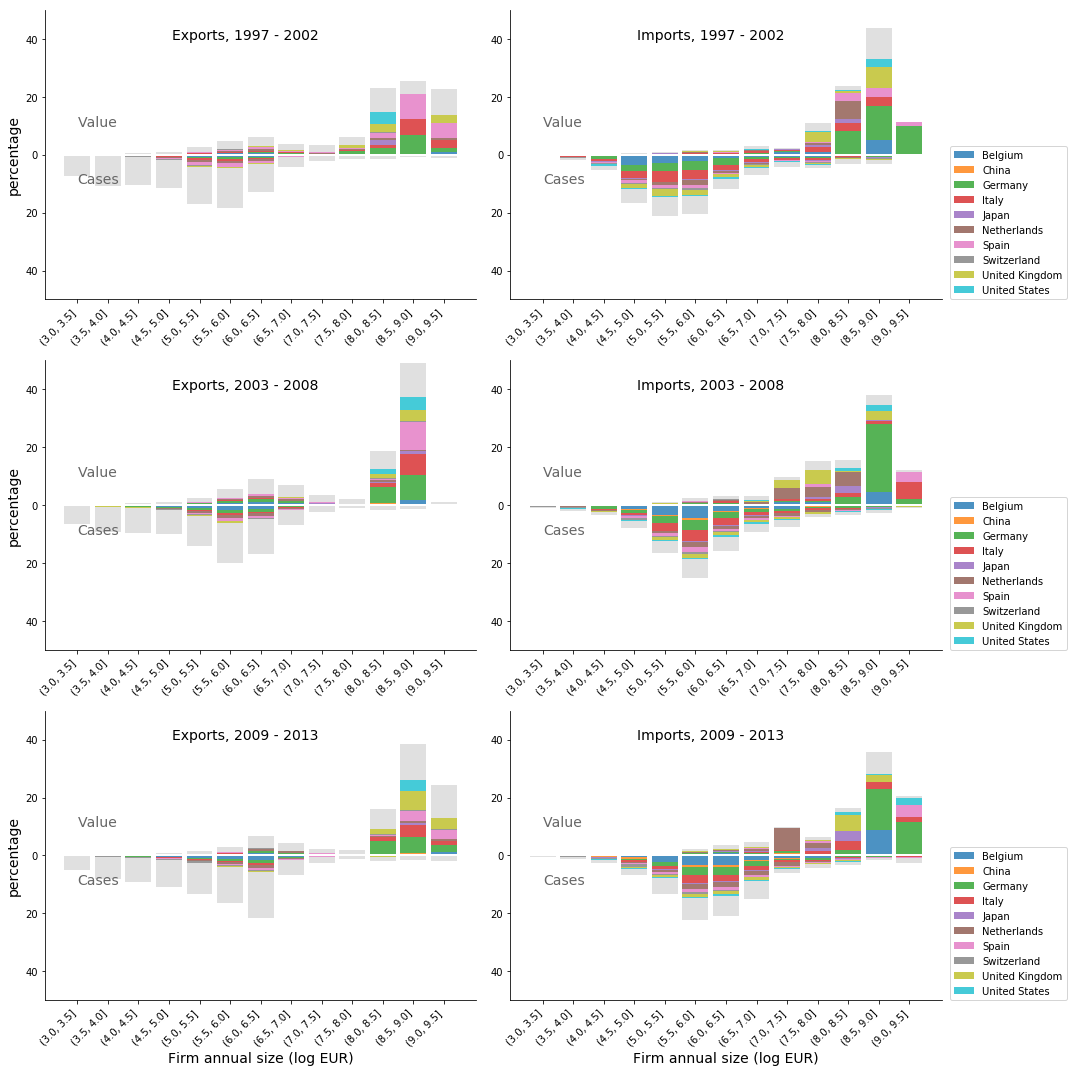

Seats (other than those of heading 9402), whether or not convertible into beds, and parts thereof


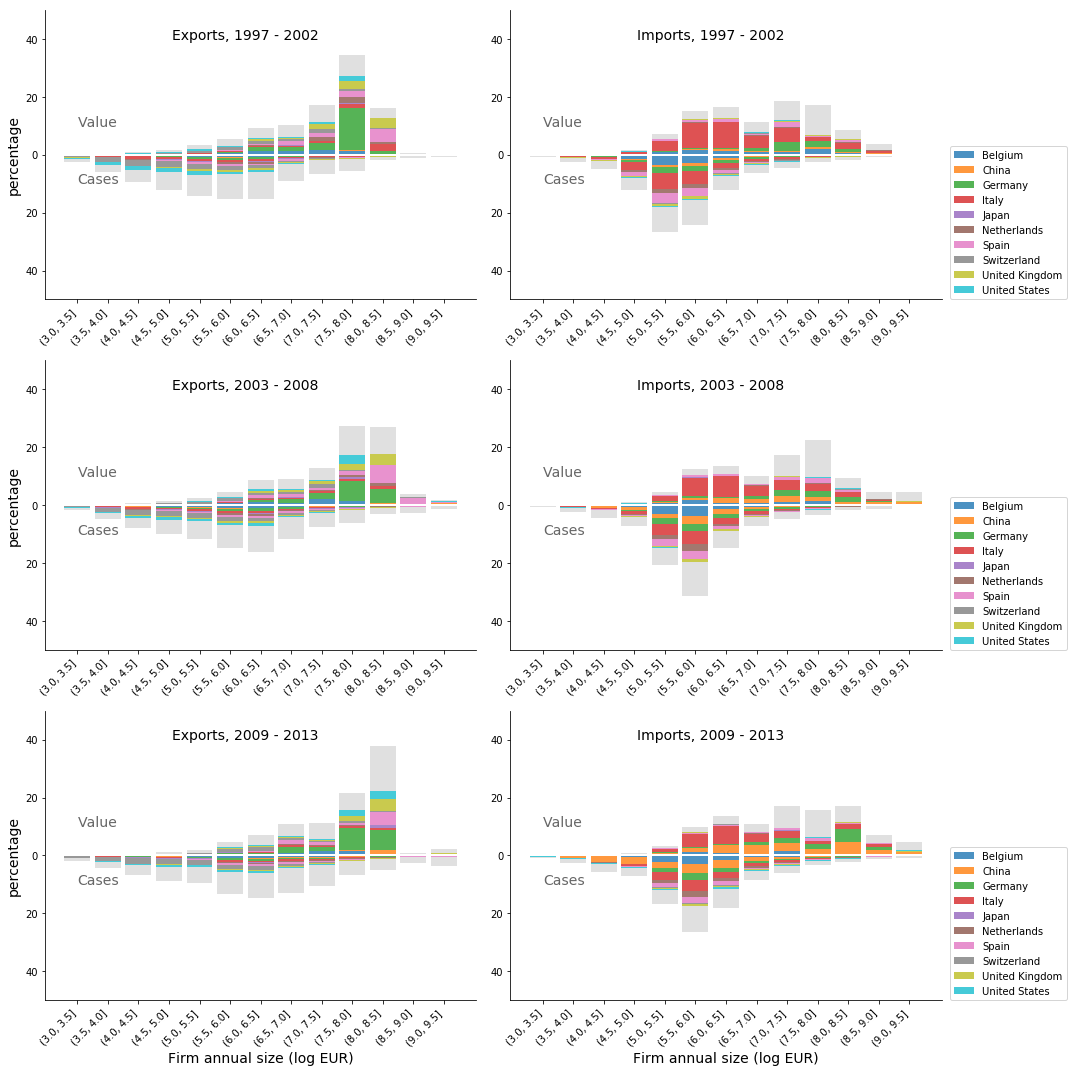

Women's or girls' suits, ensembles, jackets, blazers, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear)


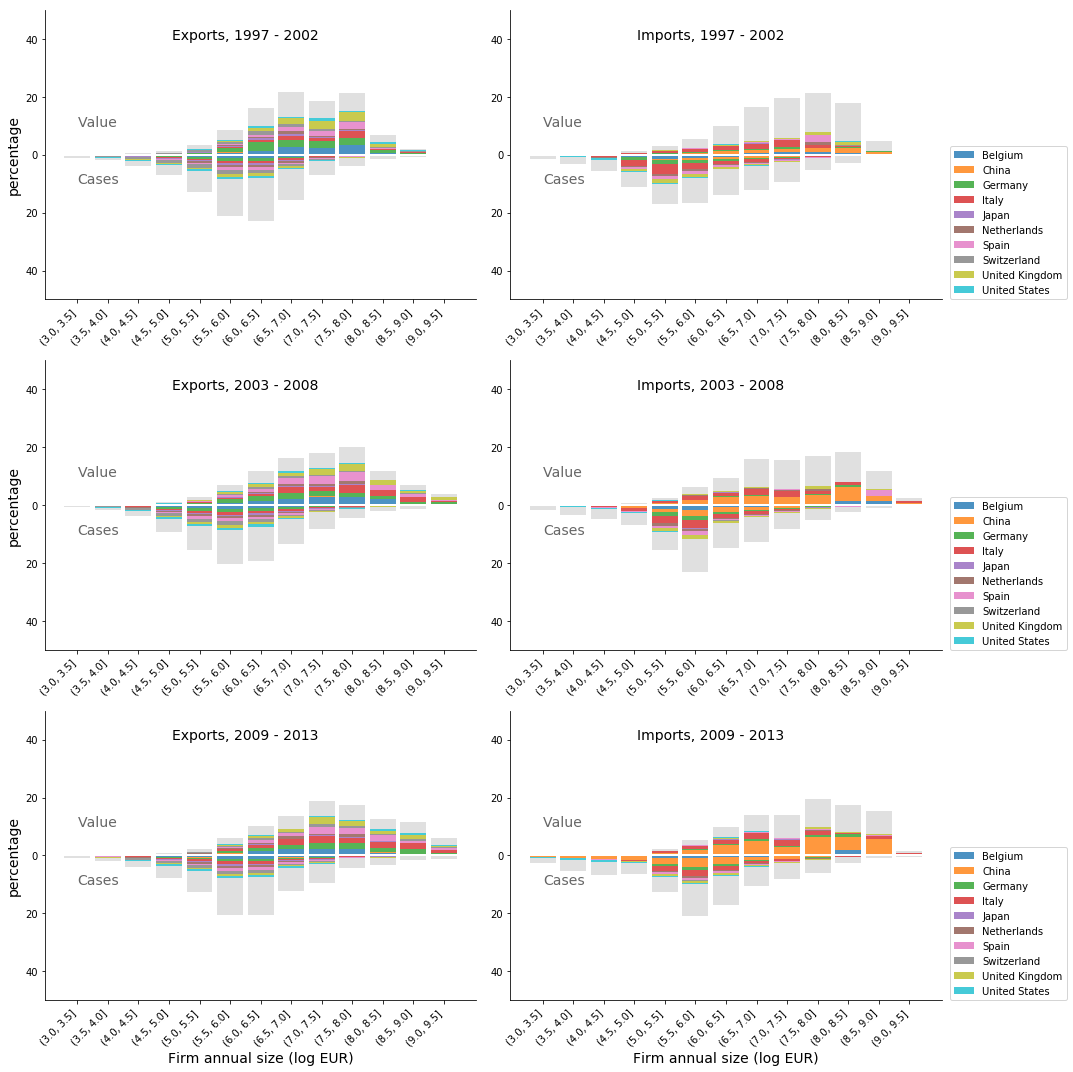

Taps, cocks, valves and similar appliances for pipes, boiler shells, tanks, vats or the like, including pressure-reducing valves and thermostatically controlled valves


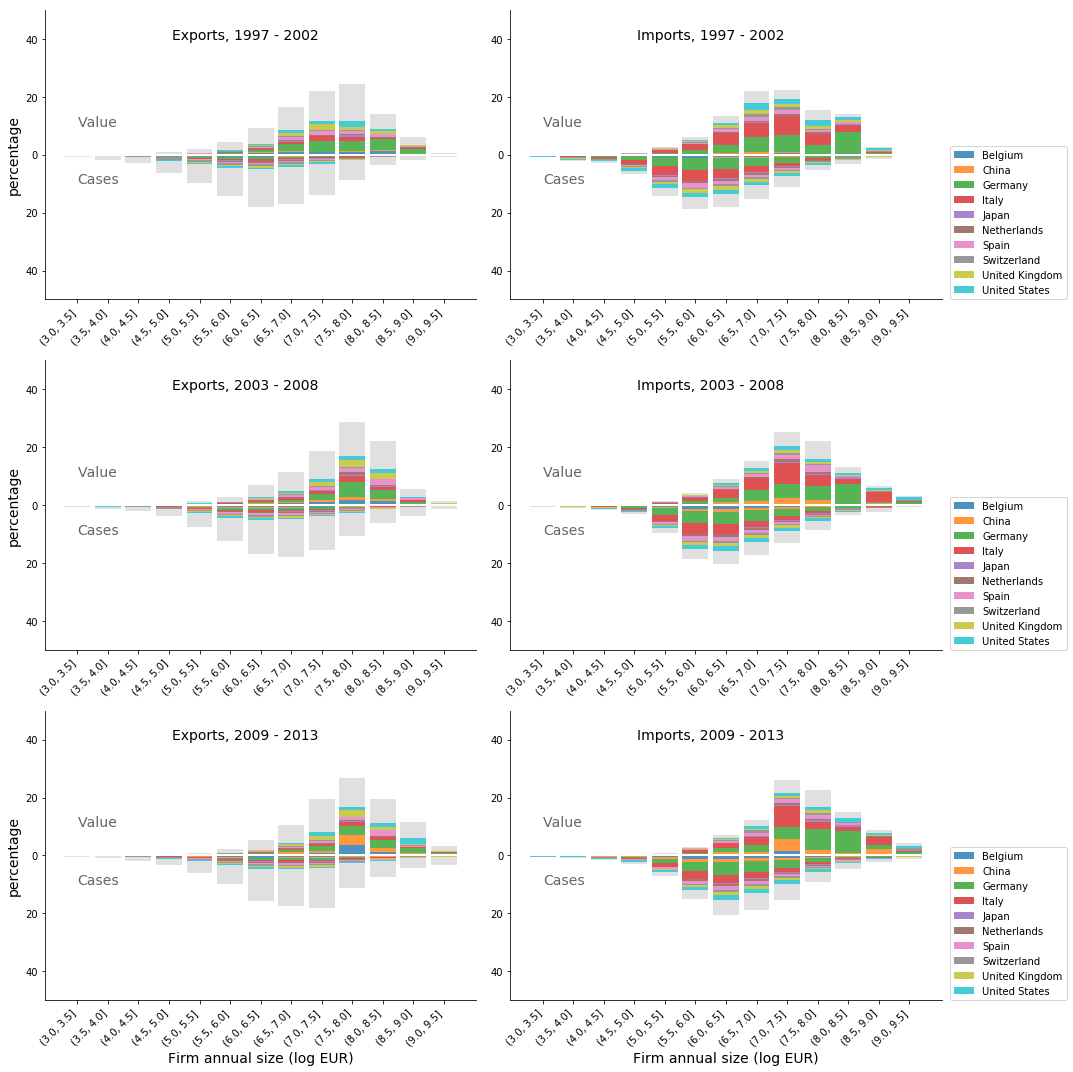

Heterocyclic compounds with nitrogen hetero-atom(s) only


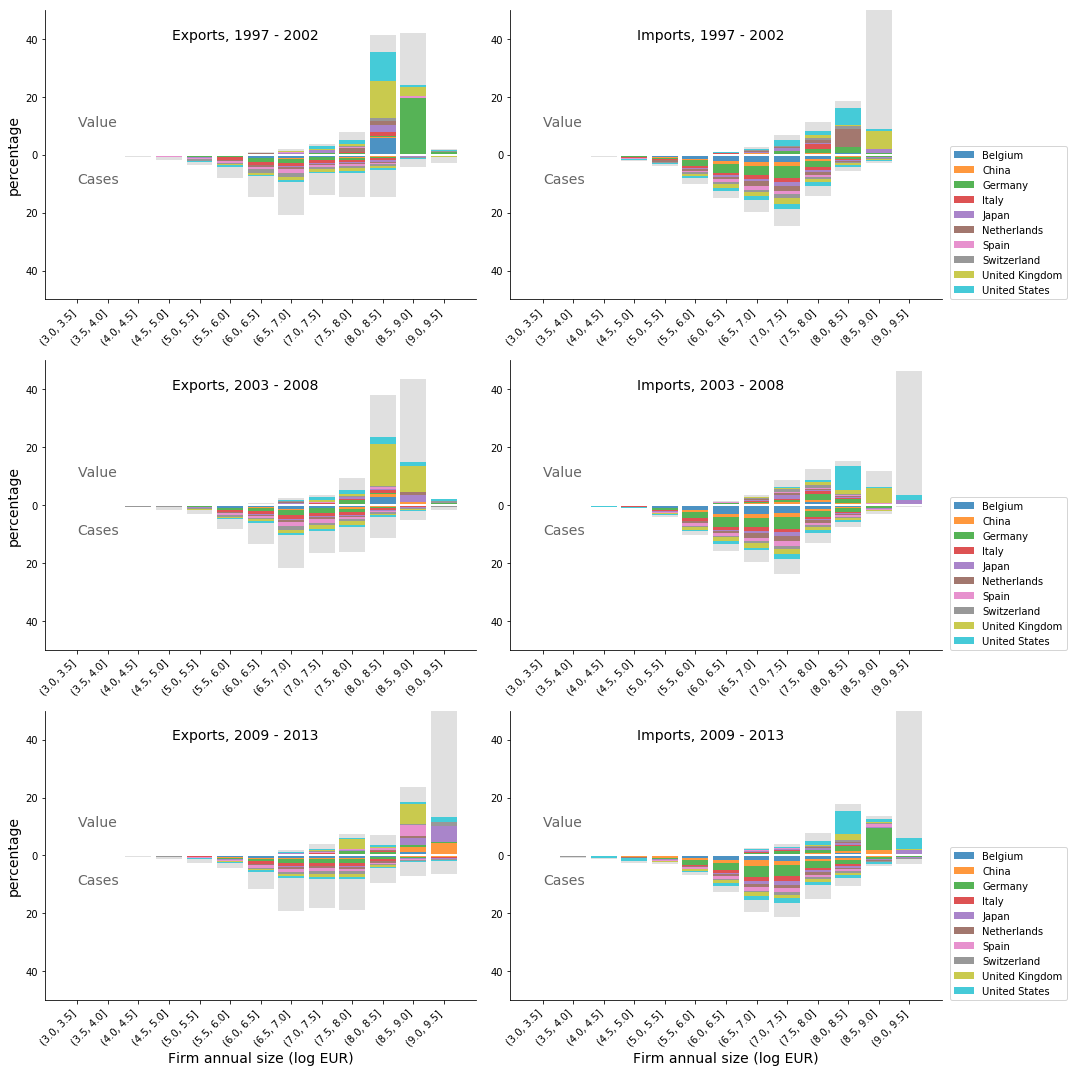

New pneumatic tyres, of rubber


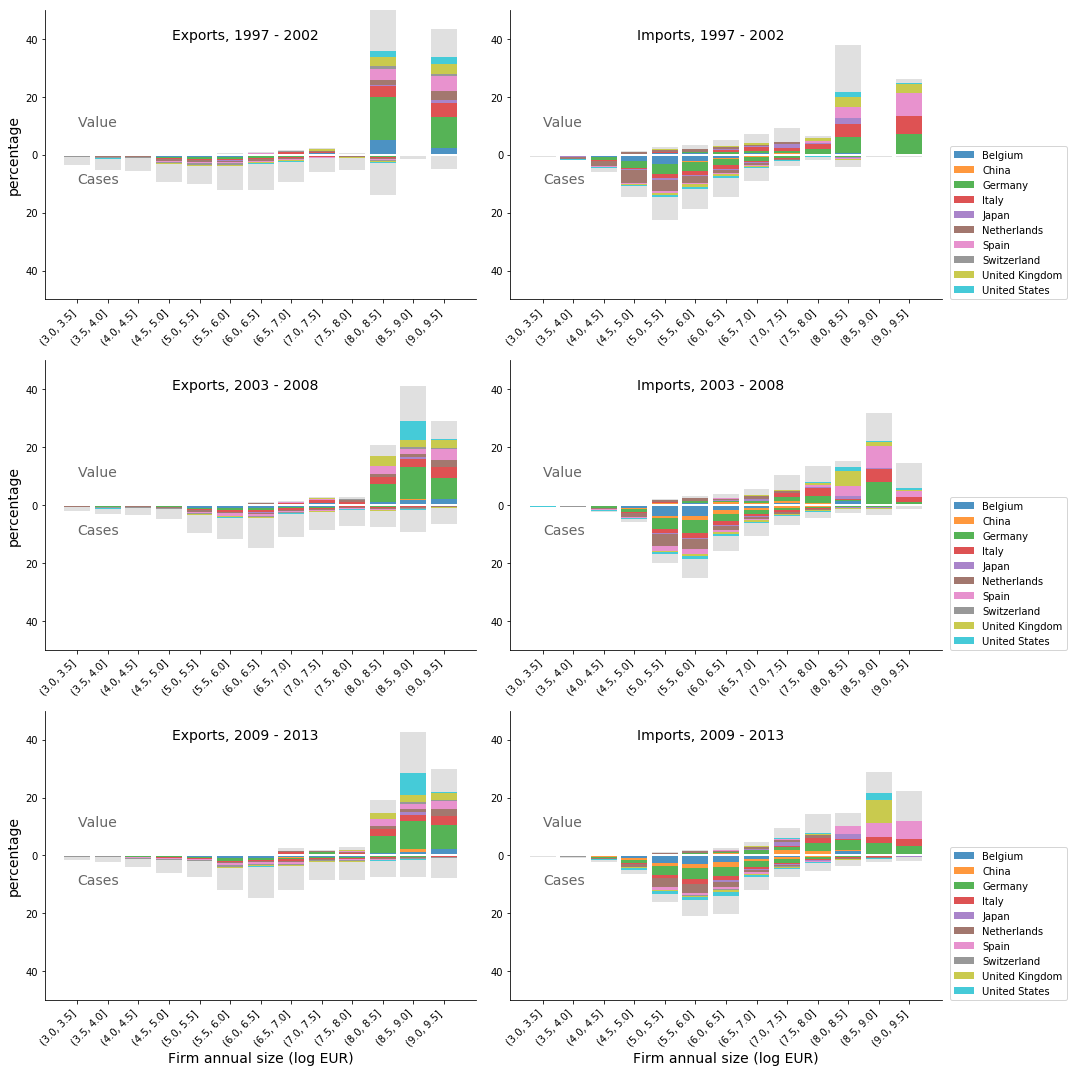

Other furniture and parts thereof


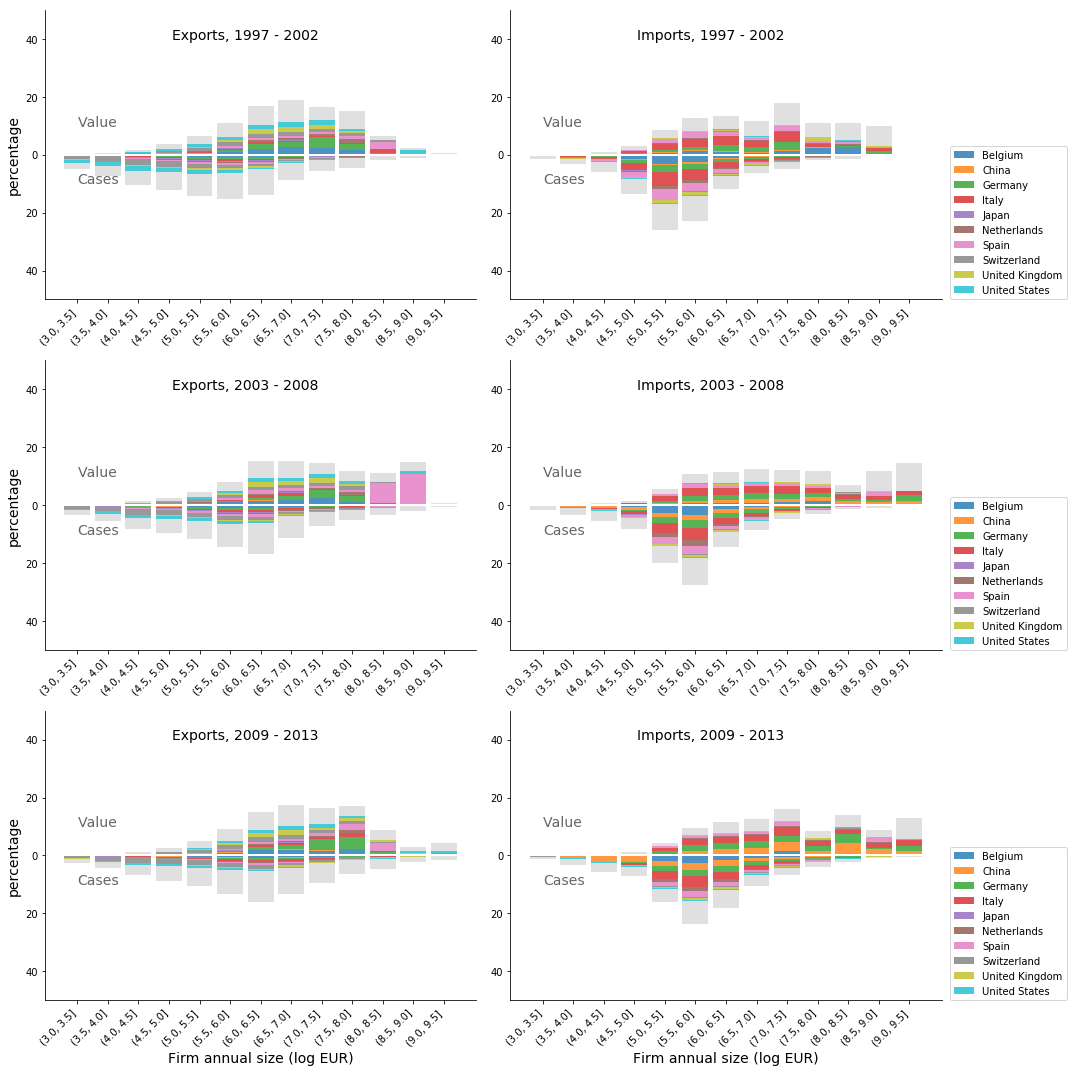

Beauty or make-up preparations and preparations for the care of the skin (other than medicaments), including sunscreen or suntan preparations; manicure or pedicure preparations


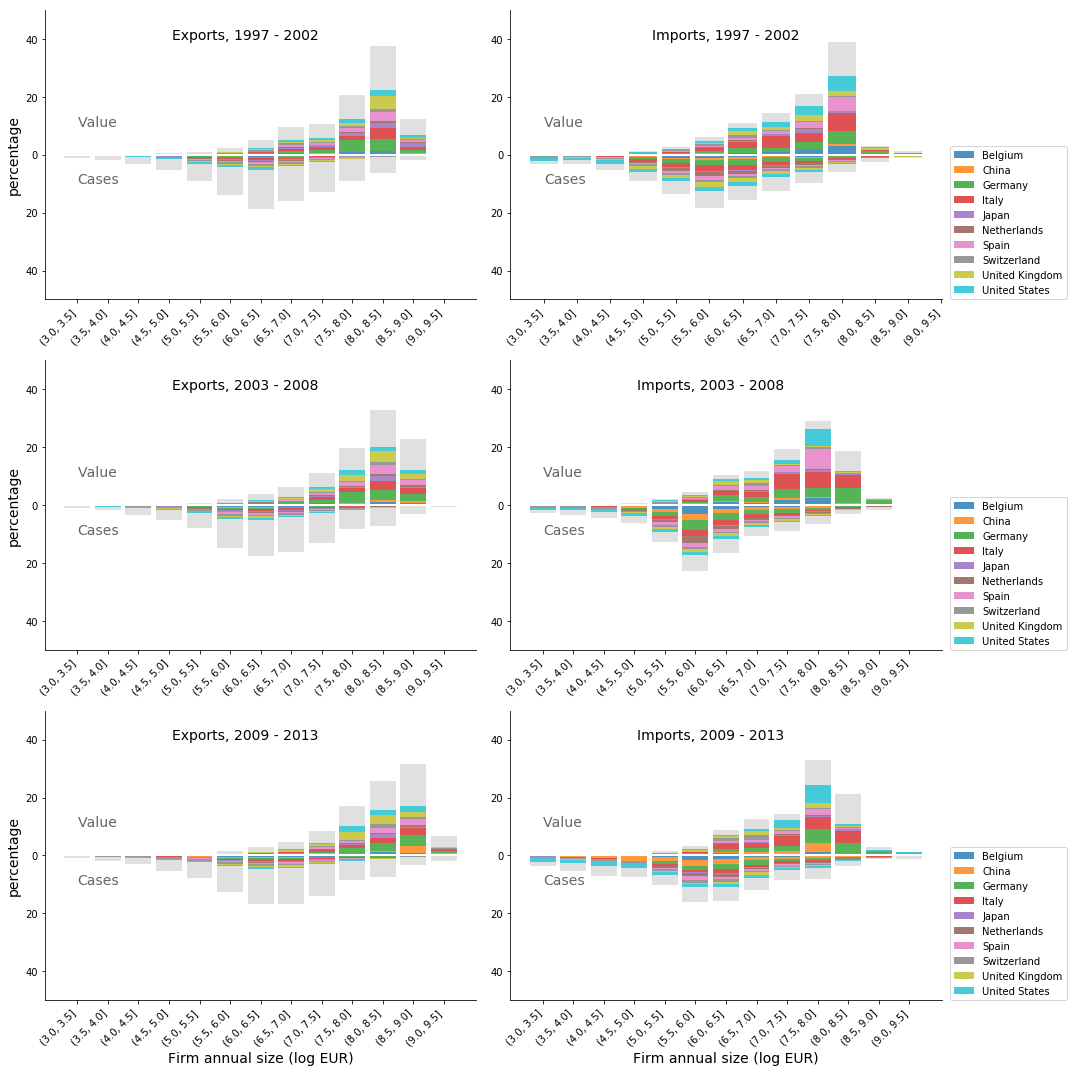

Preparations of a kind used in animal feeding


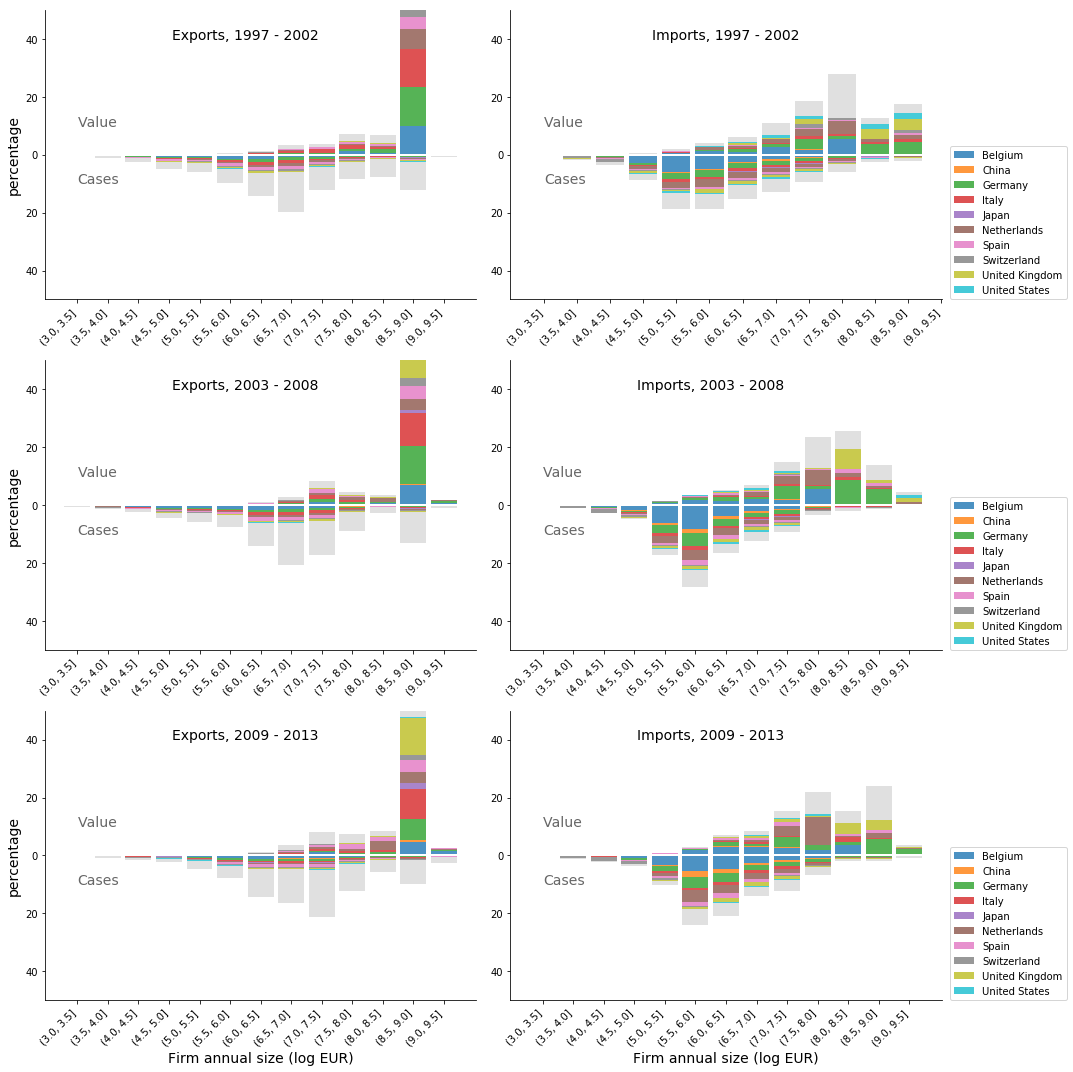

Undenatured ethyl alcohol of an alcoholic strength by volume of less than 80 % vol; spirits, liqueurs and other spirituous beverages


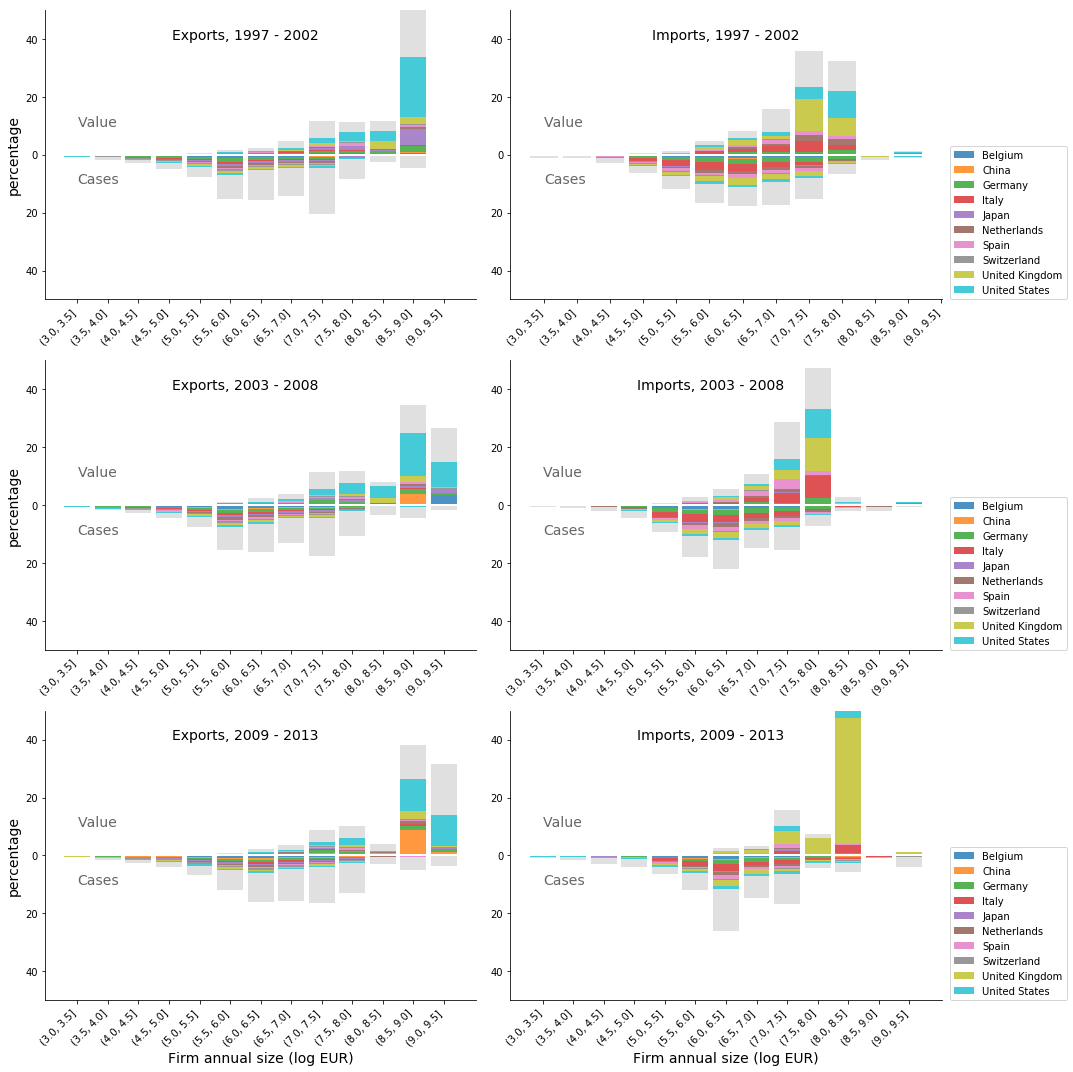

Footwear with outer soles of rubber, plastics, leather or composition leather and uppers of leather


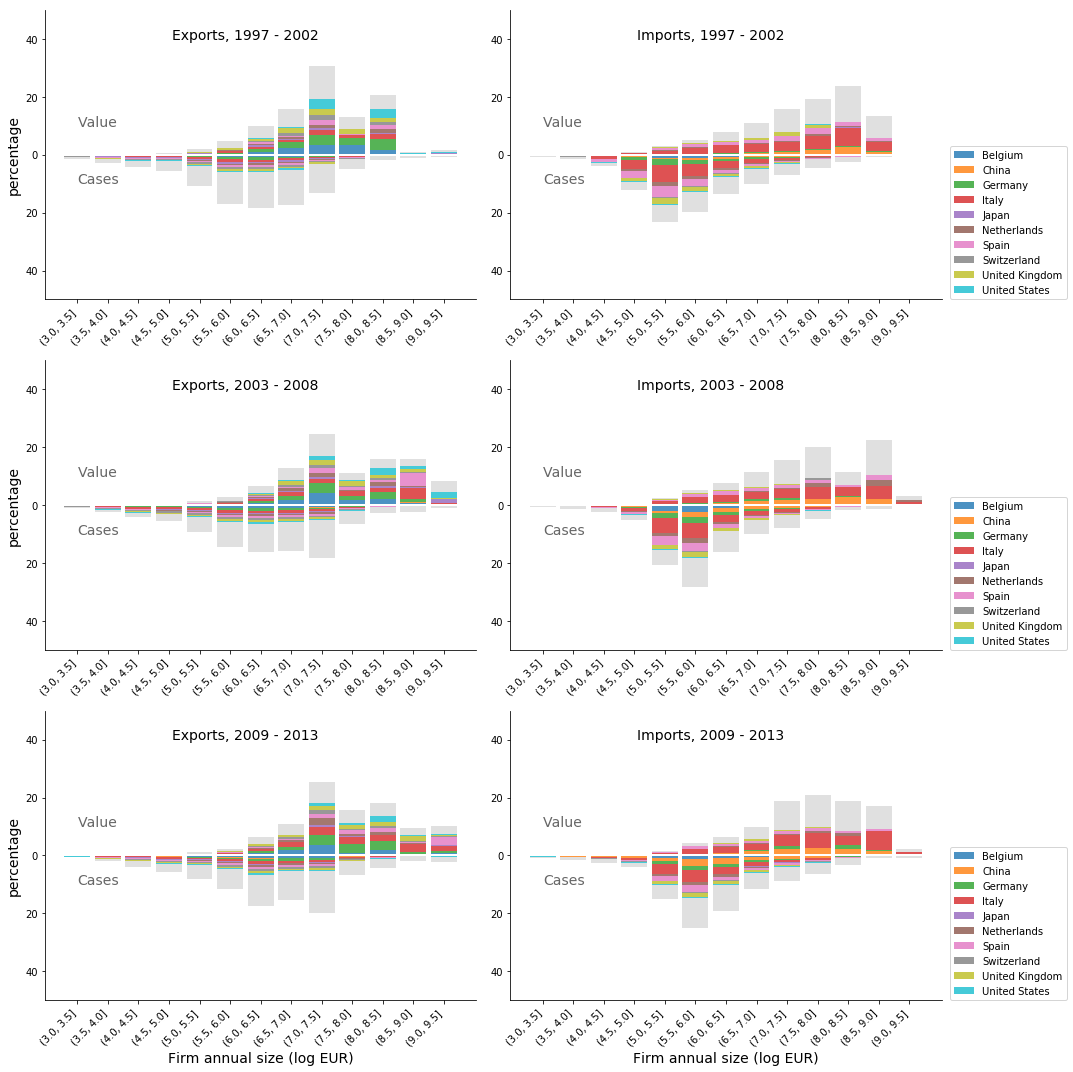

Electrical apparatus for switching or protecting electrical circuits, or for making connections to or in electrical circuits (for example, switches, relays, fuses, surge suppressors, plugs, sockets, lamp holders and other connectors, junction boxes), for a voltage not exceeding 1000 V; connectors for optical fibres, optical fibre bundles or cables


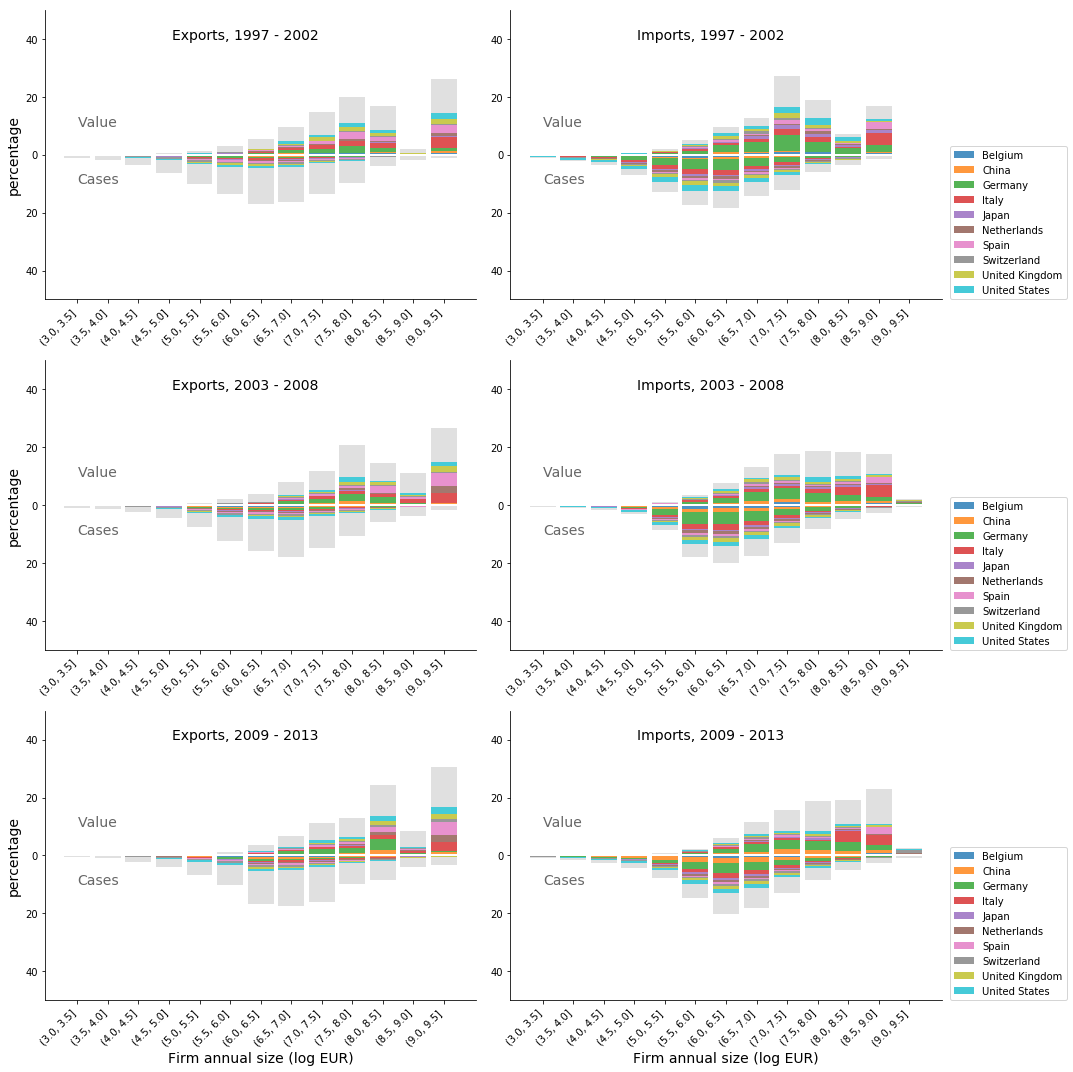

Trunks, suitcases, vanity cases, executive-cases, briefcases, school satchels, spectacle cases, binocular cases, camera cases, musical instrument cases, gun cases, holsters and similar containers; travelling-bags, insulated food or beverages bags, toilet bags, rucksacks, handbags, shopping-bags, wallets, purses, map-cases, cigarette-cases, tobacco-pouches, tool bags, sports bags, bottle-cases, jewellery boxes, powder boxes, cutlery cases and similar containers, of leather or of composition leather, of sheeting of plastics, of textile materials, of vulcanised fibre or of paperboard, or wholly or mainly covered with such materials or with paper


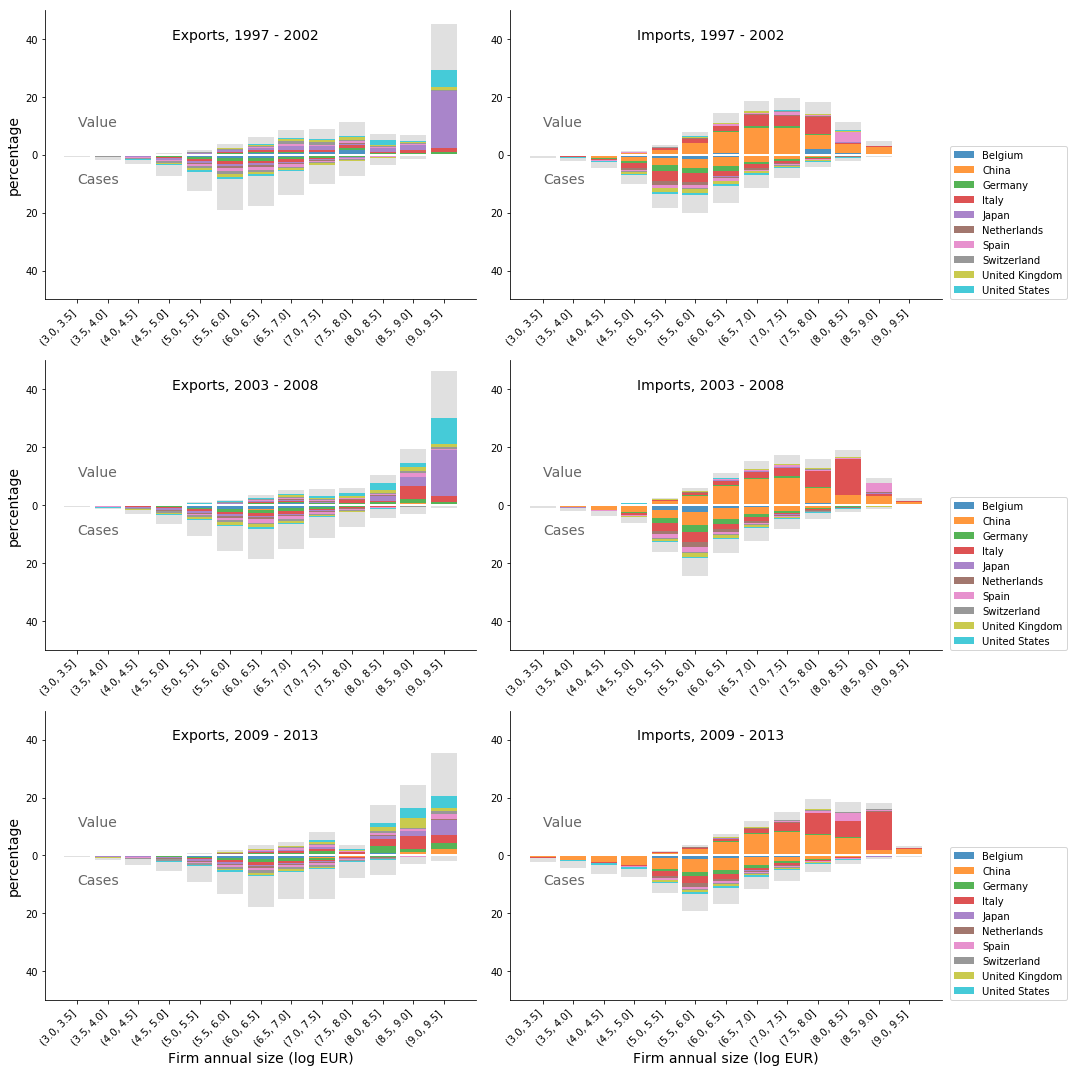

Electronic integrated circuits


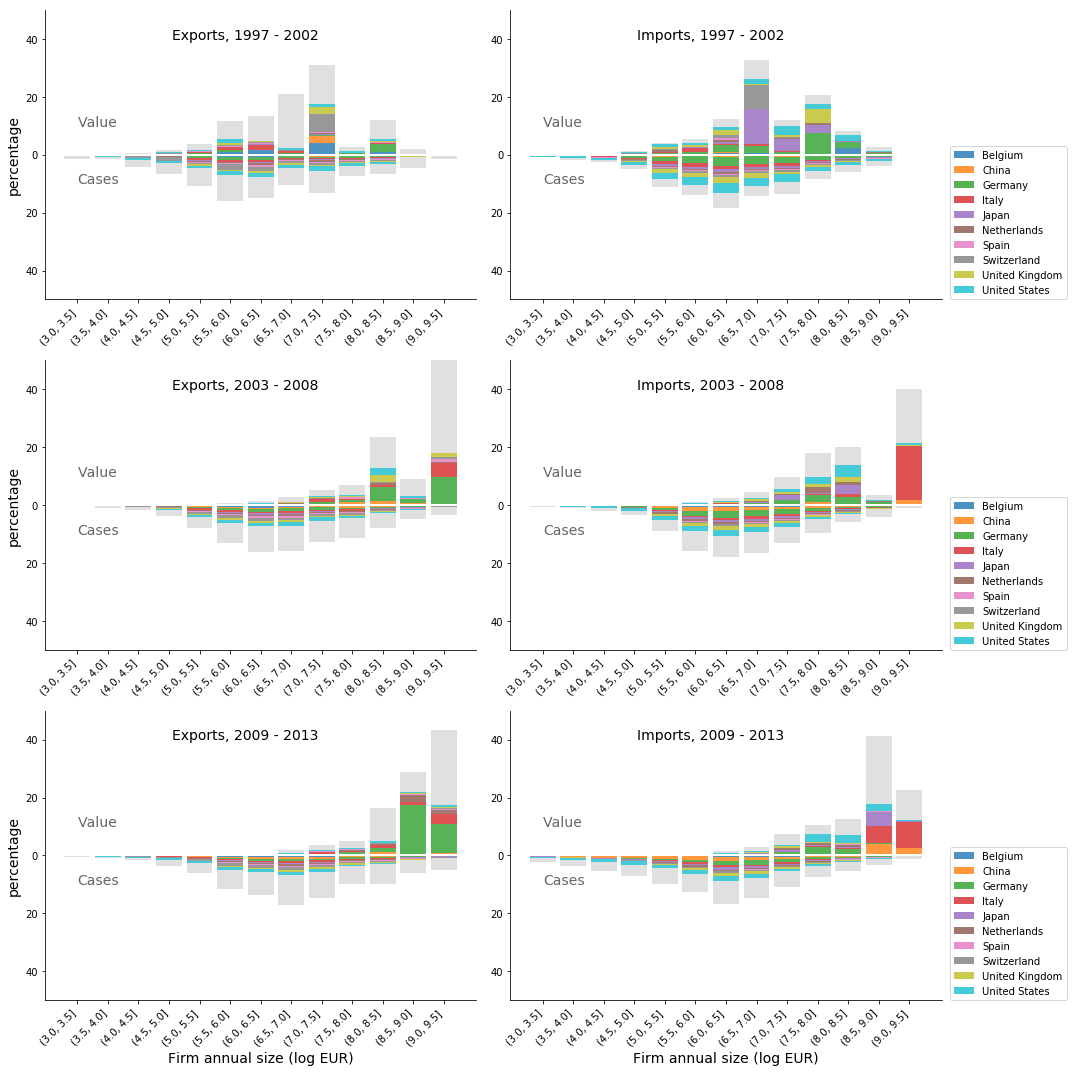

Petroleum oils and oils obtained from bituminous minerals, crude


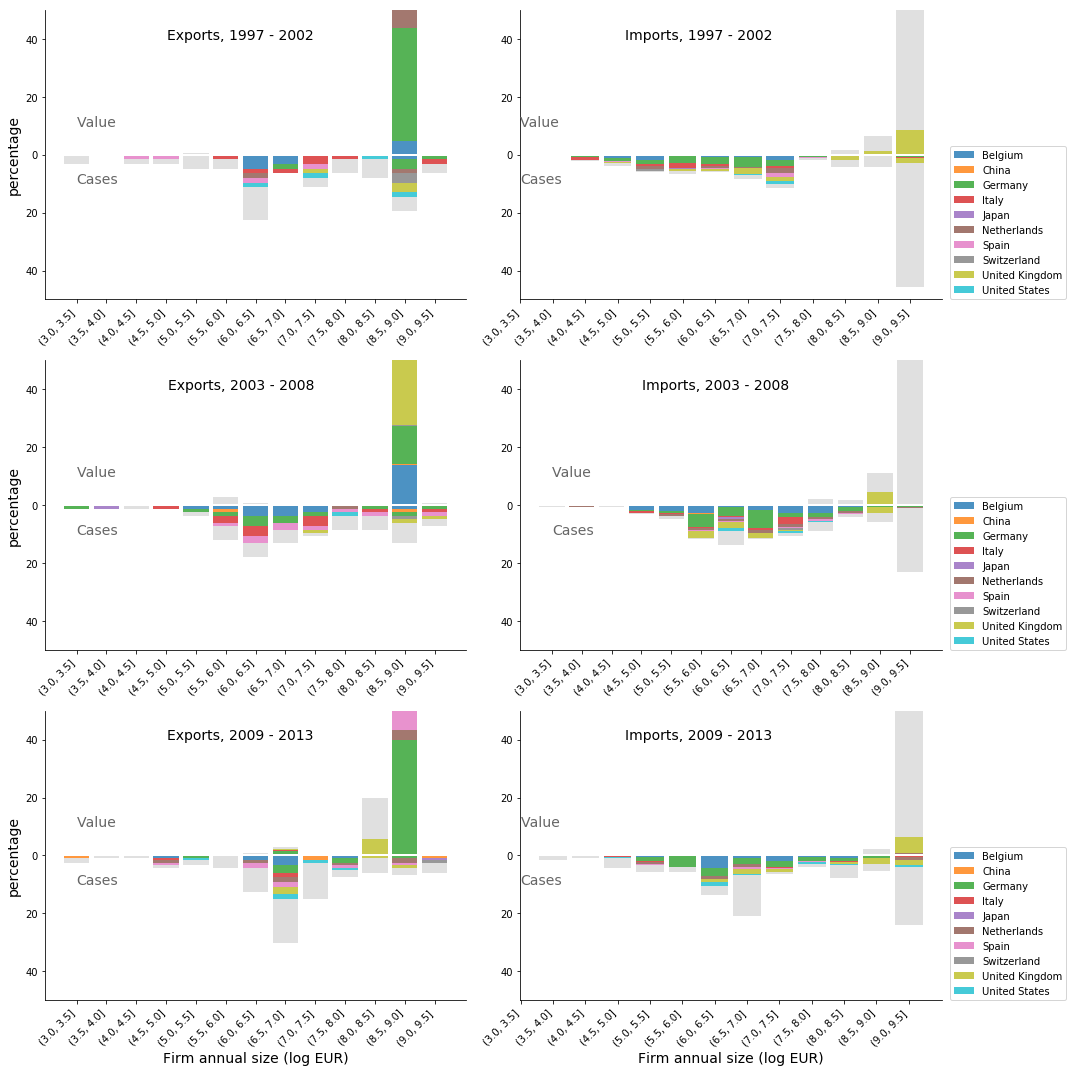

Petroleum gases and other gaseous hydrocarbons


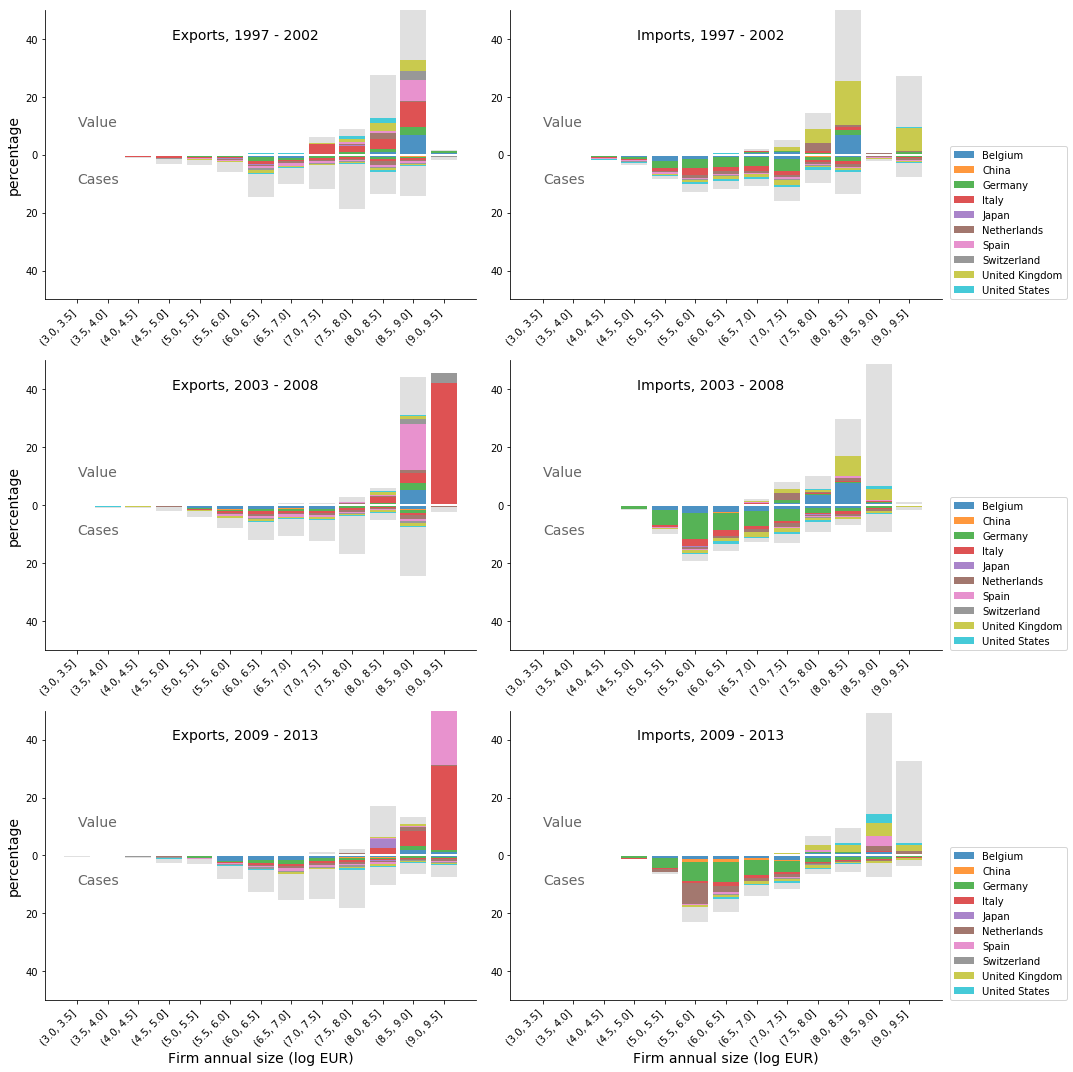

Telephone sets, including telephones for cellular networks or for other wireless networks; other apparatus for the transmission or reception of voice, images or other data, including apparatus for communication in a wired or wireless network (such as a local or wide area network), other than transmission or reception apparatus of heading 8443, 8525, 8527 or 8528


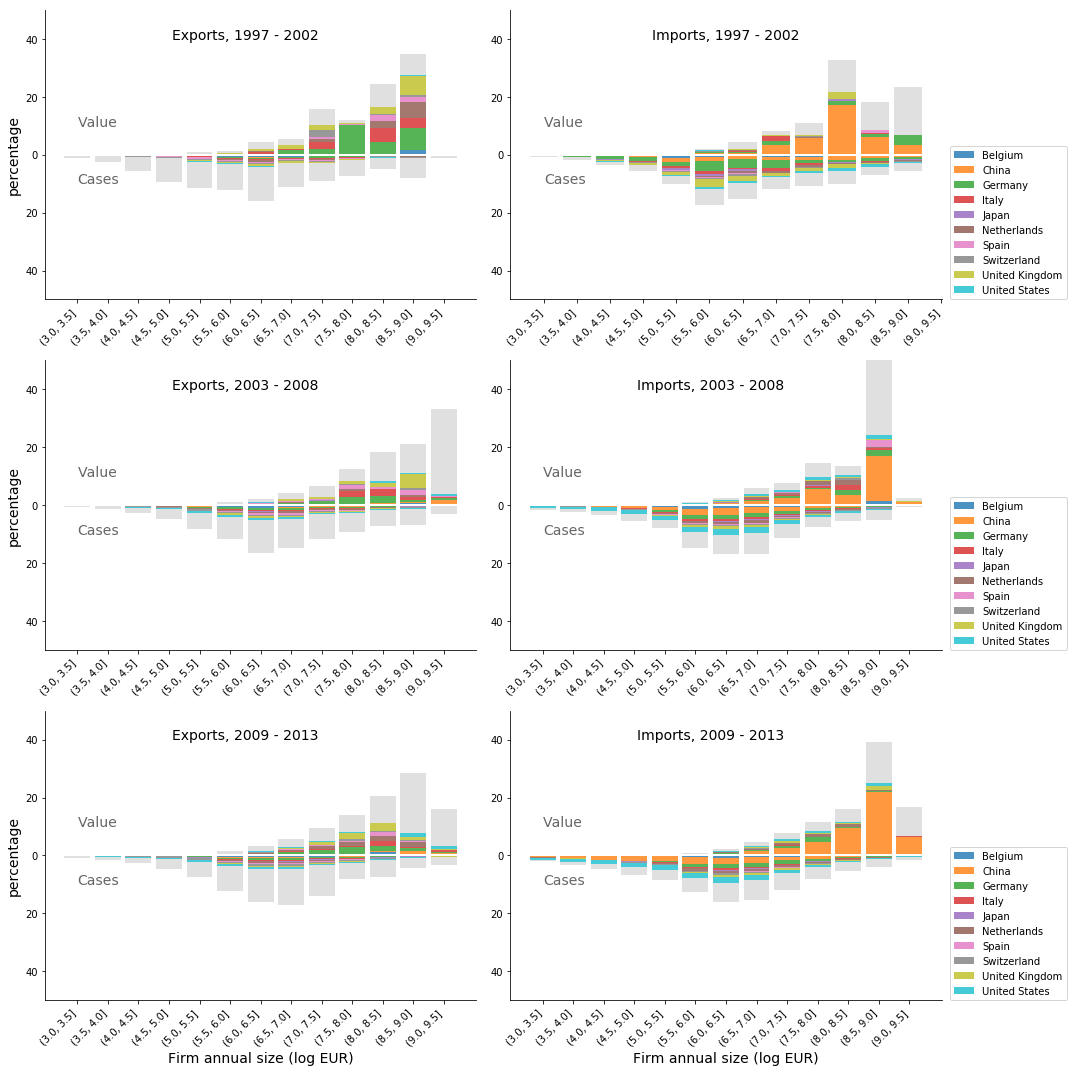

Turbojets, turbopropellers and other gas turbines


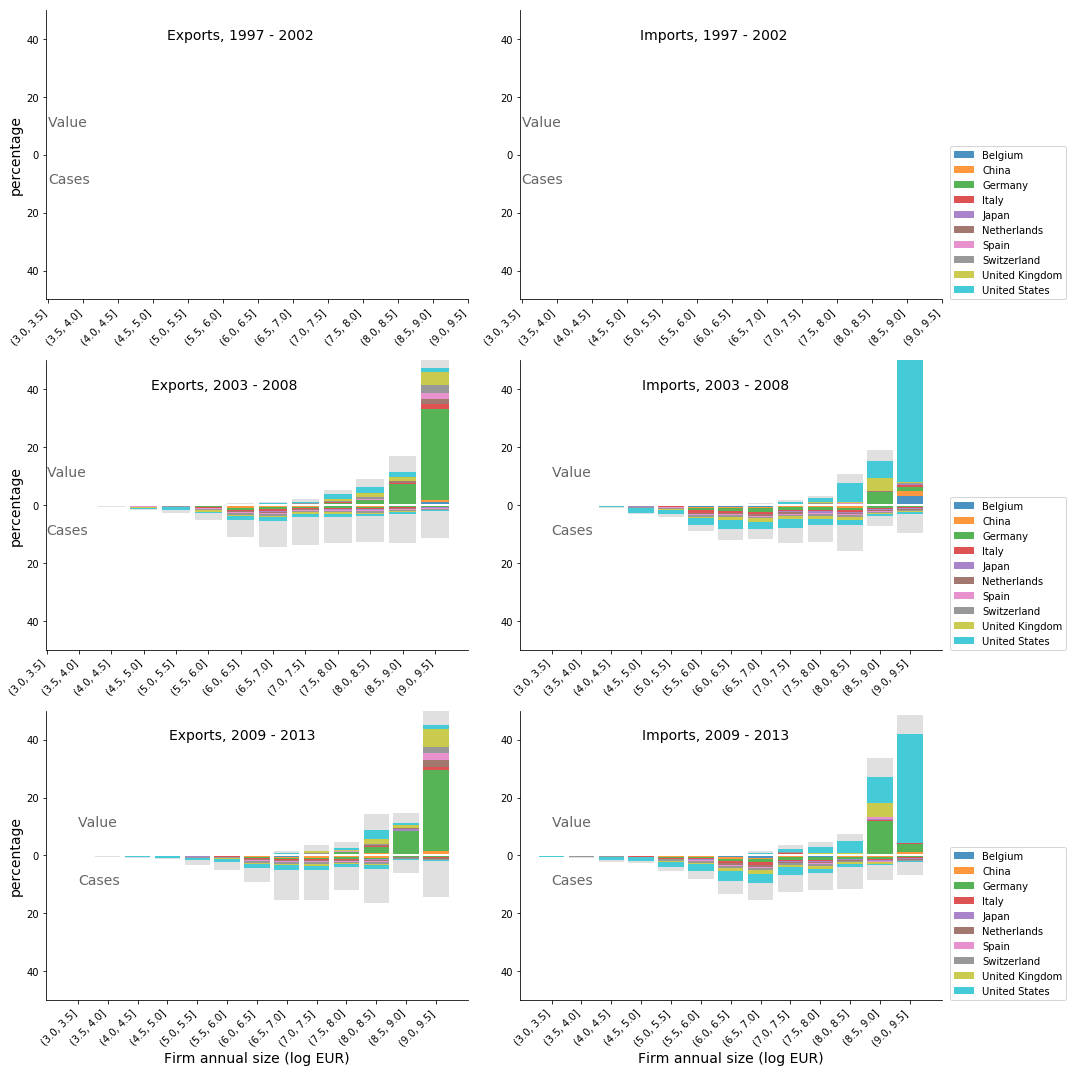

Automatic data-processing machines and units thereof; magnetic or optical readers, machines for transcribing data onto data media in coded form and machines for processing such data, not elsewhere specified or included


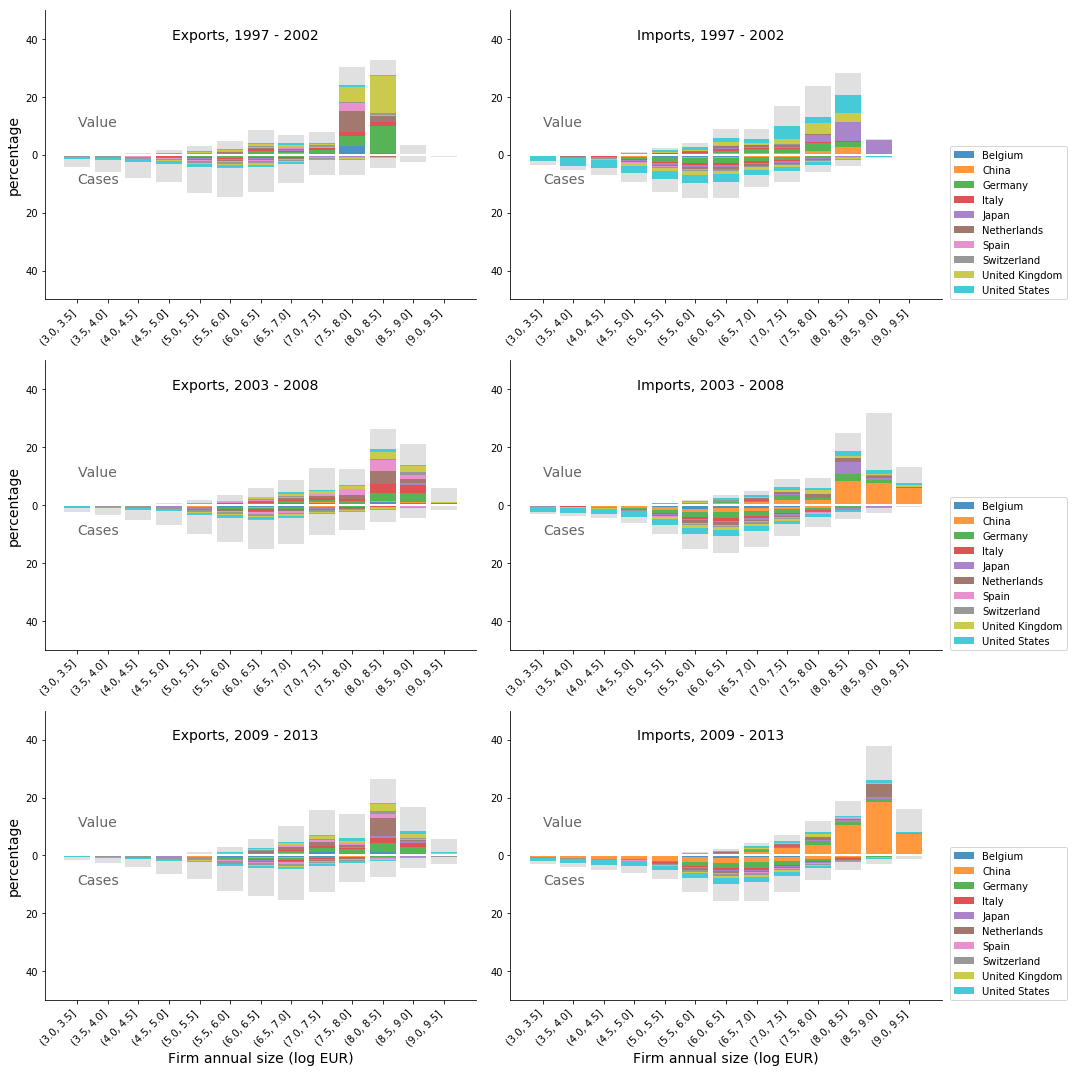

Other aircraft (for example, helicopters, aeroplanes); spacecraft (including satellites) and suborbital and spacecraft launch vehicles


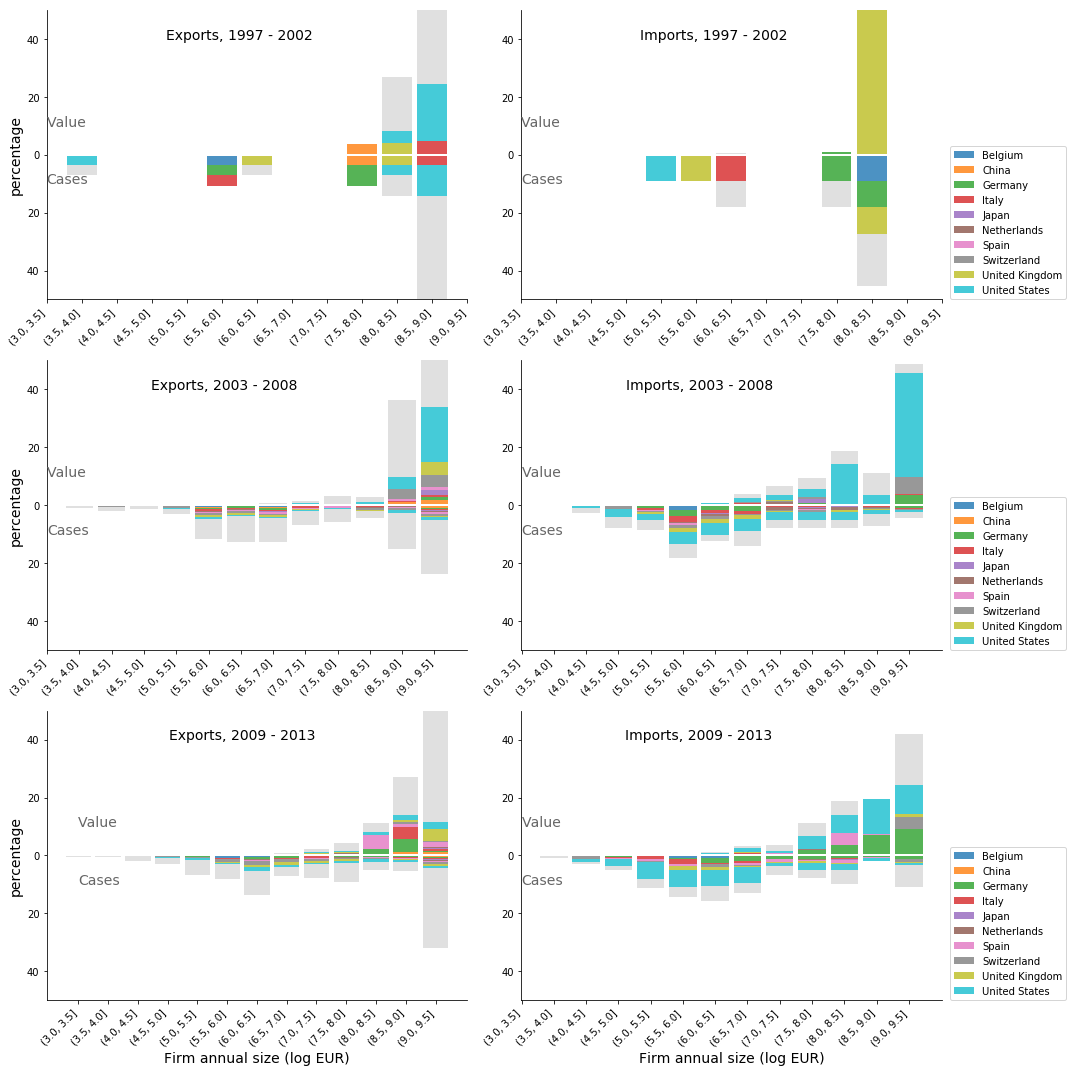

Motor vehicles for the transport of goods


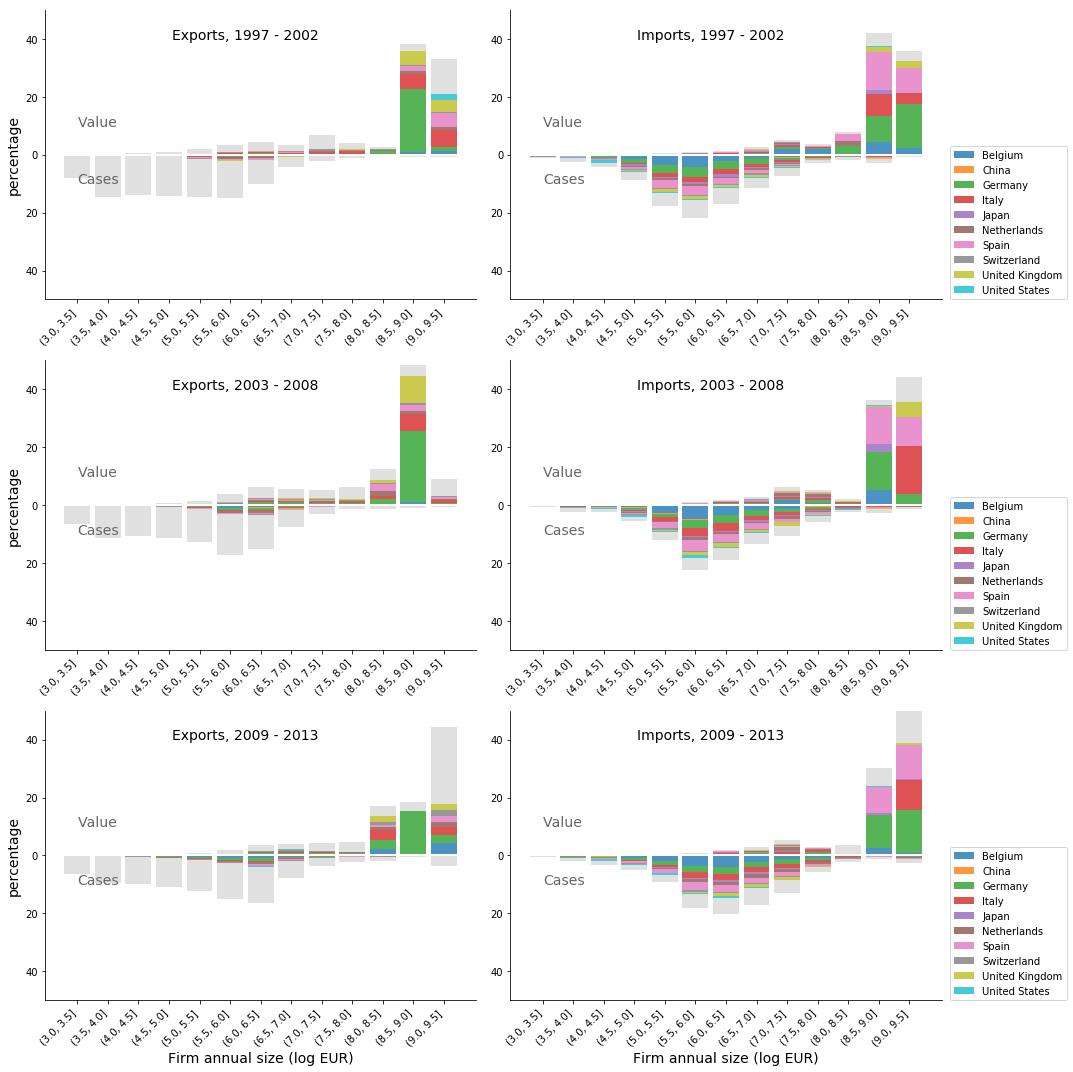

Medicaments (excluding goods of heading 3002, 3005 or 3006) consisting of mixed or unmixed products for therapeutic or prophylactic uses, put up in measured doses (including those in the form of transdermal administration systems) or in forms or packings for retail sale


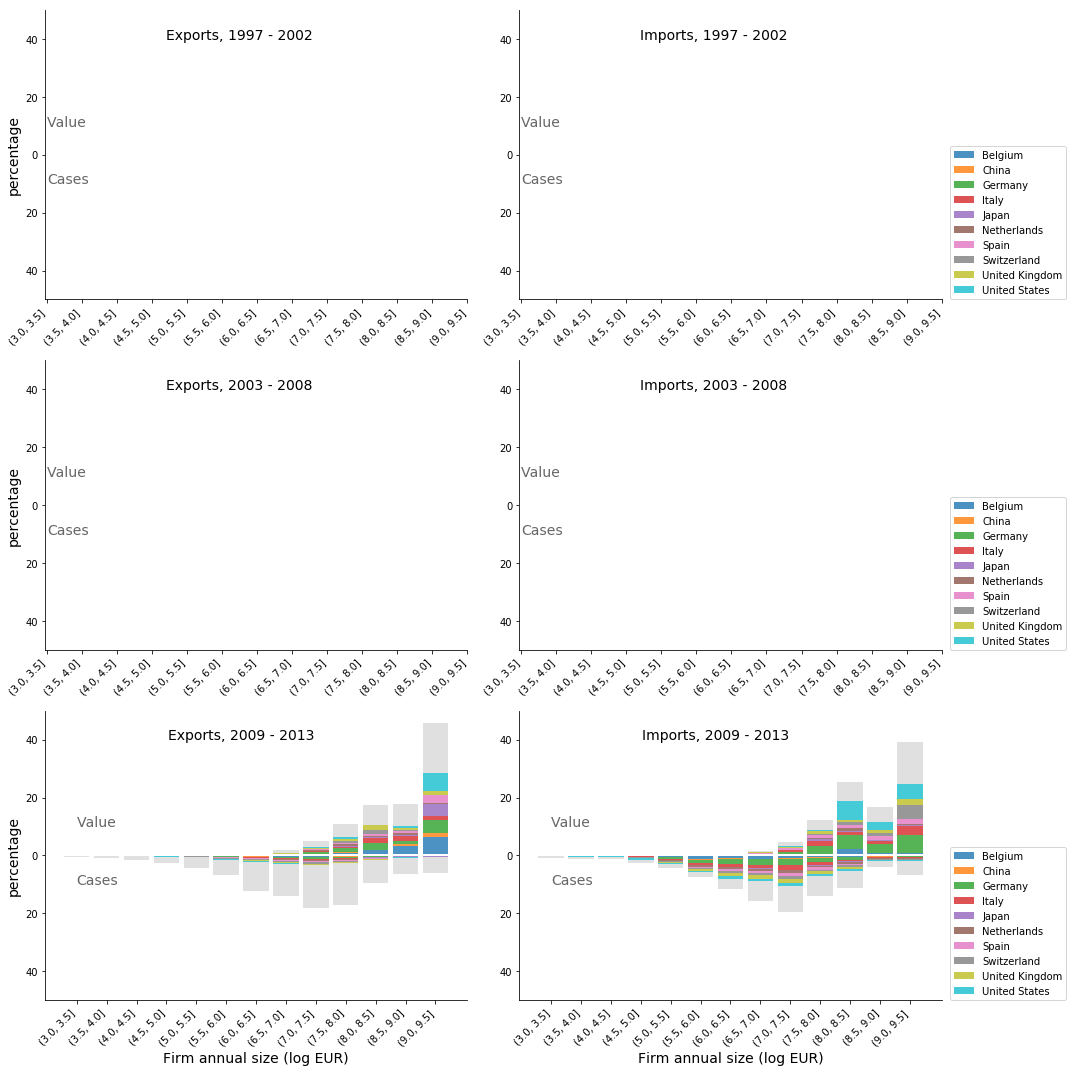

Wine of fresh grapes, including fortified wines; grape must other than that of heading 2009


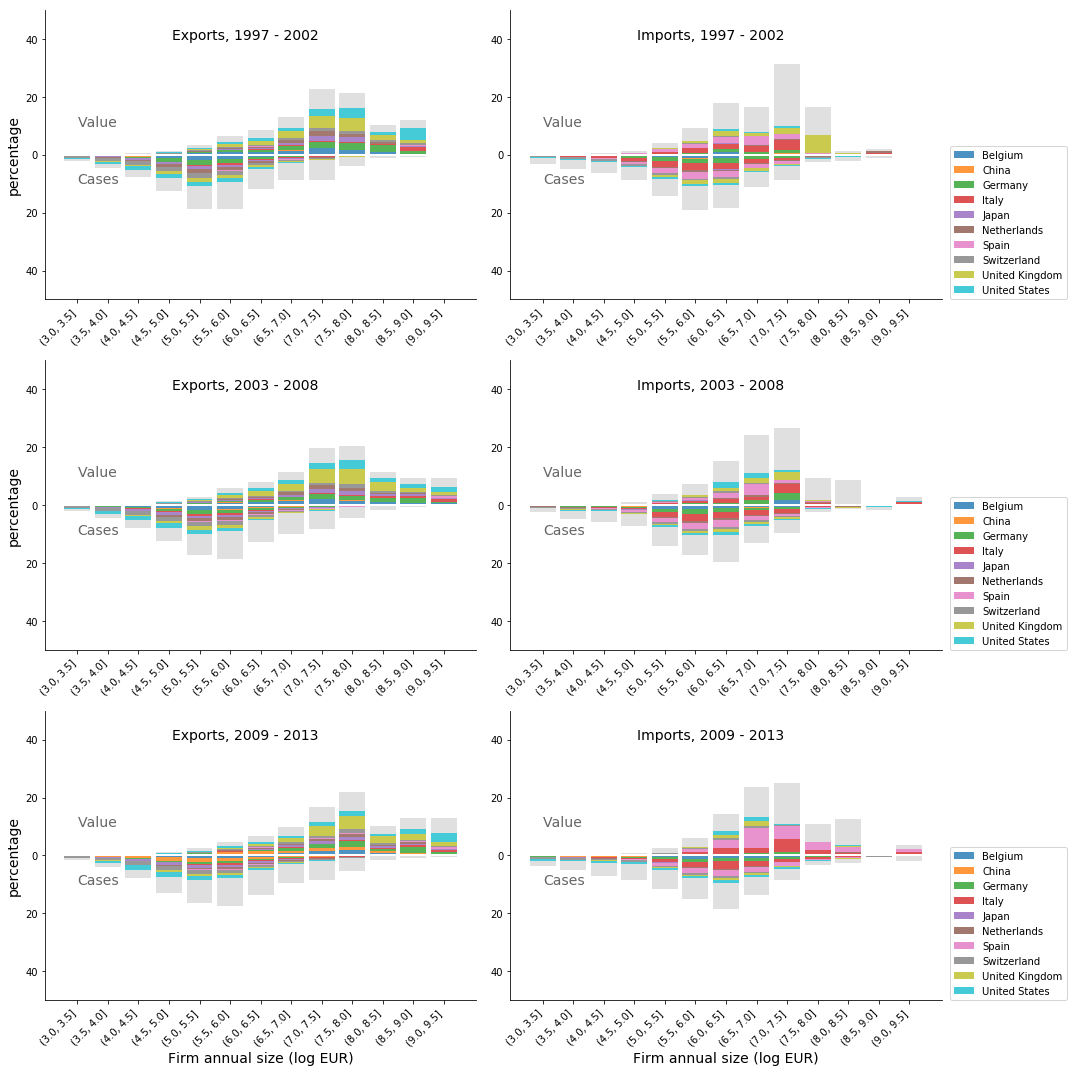

Parts and accessories of the motor vehicles of headings 8701 to 8705


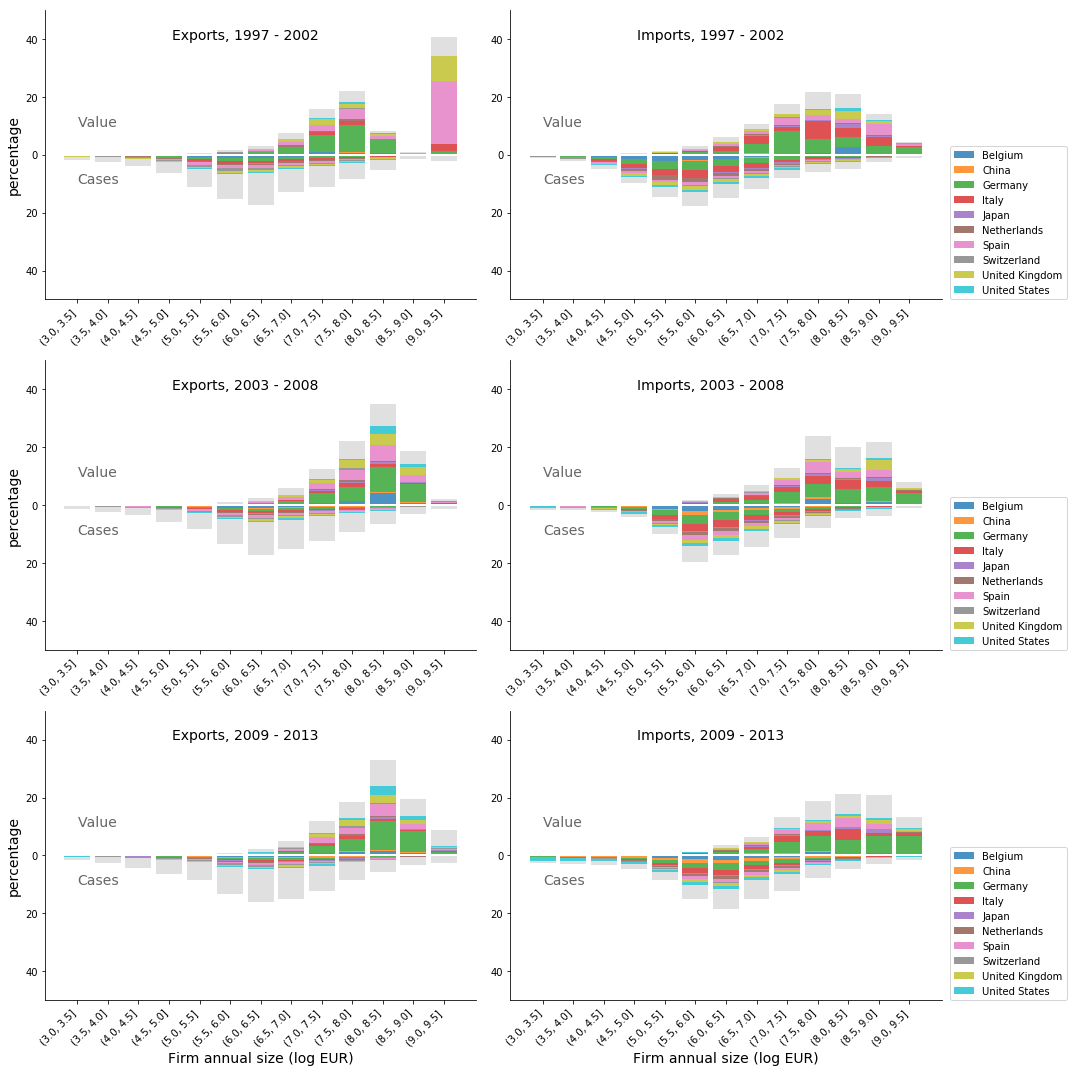

Petroleum oils and oils obtained from bituminous minerals, other than crude; preparations not elsewhere specified or included, containing by weight 70 % or more of petroleum oils or of oils obtained from bituminous minerals, these oils being the basic constituents of the preparations; waste oils


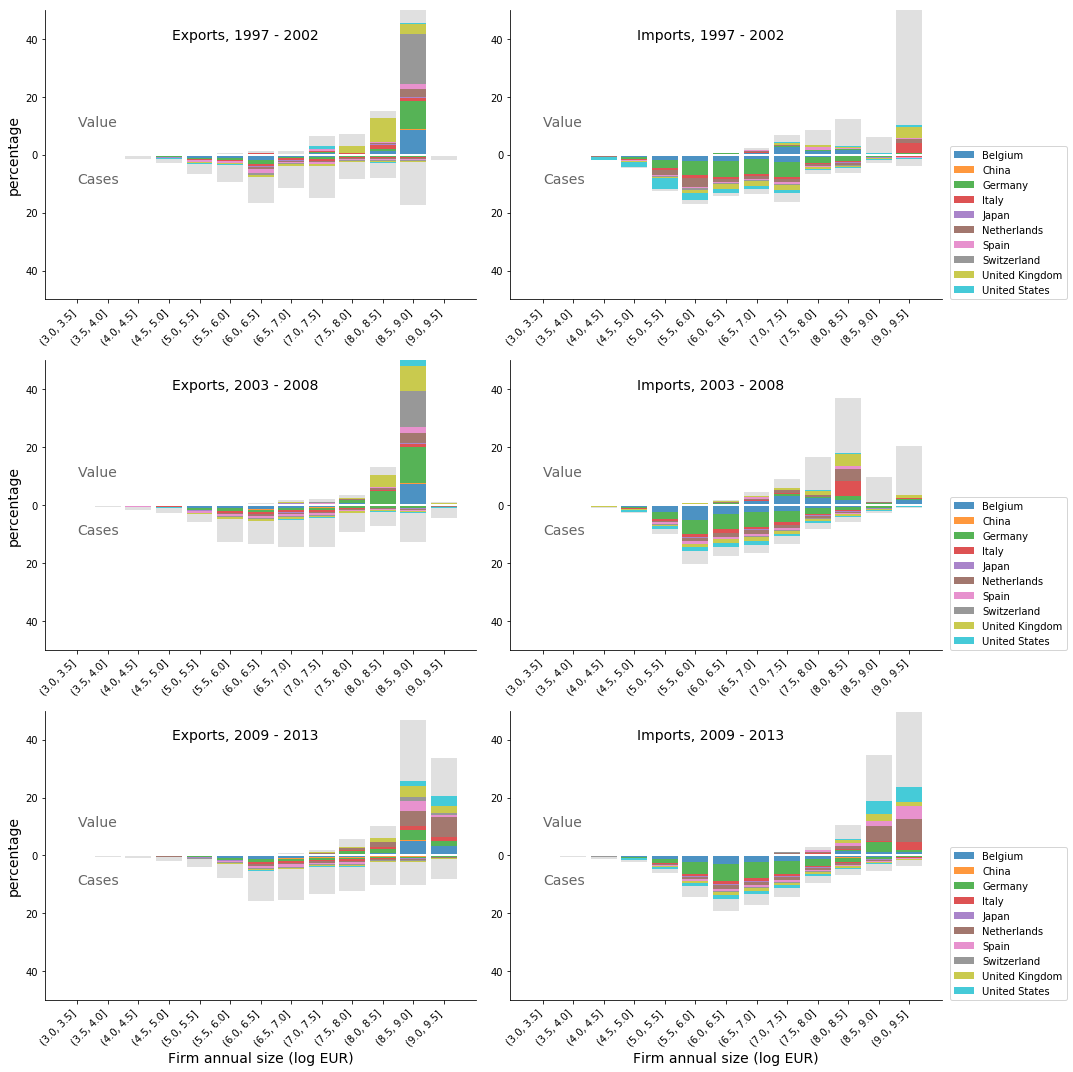

Motor cars and other motor vehicles principally designed for the transport of persons (other than those of heading 8702), including station wagons and racing cars


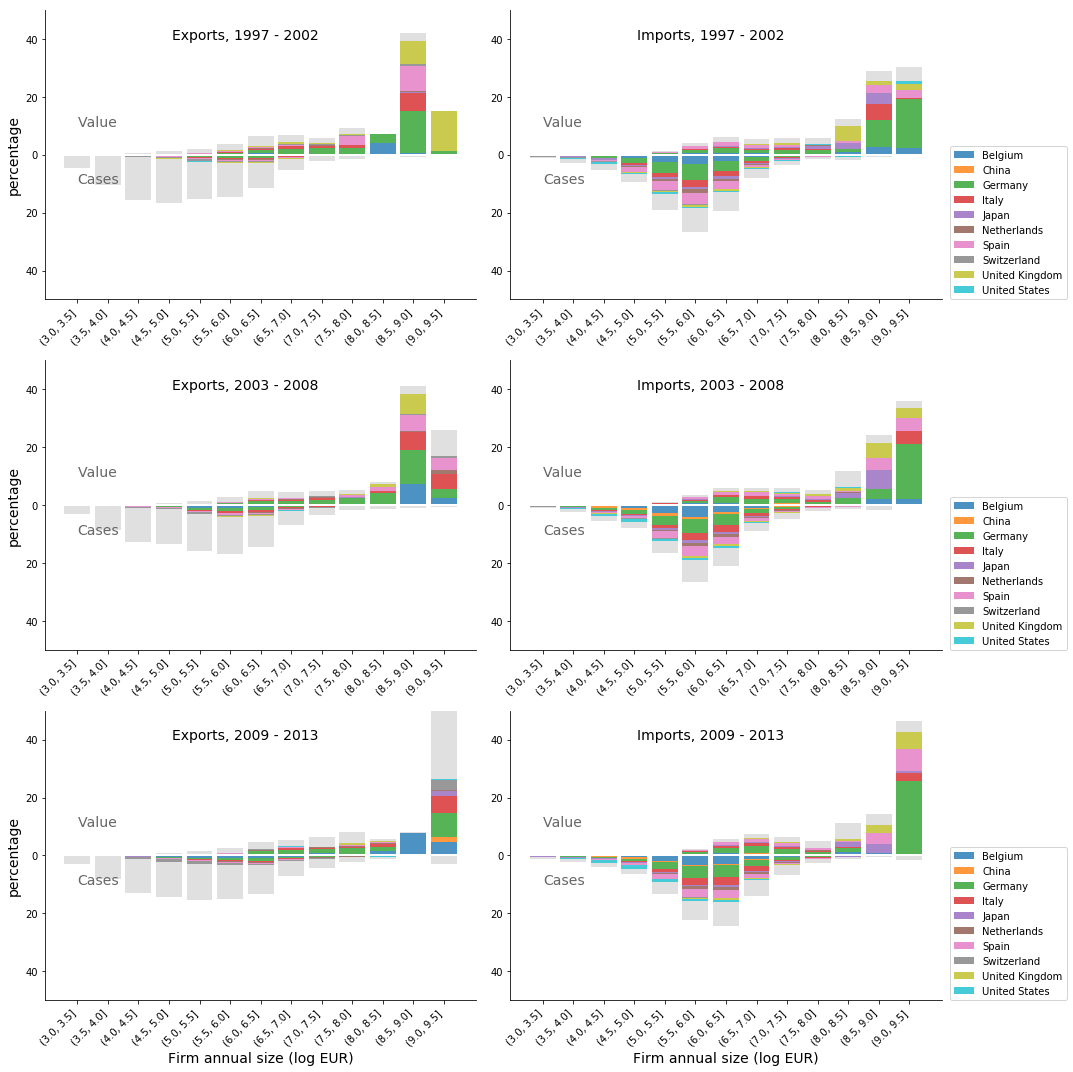

In [120]:
from pylab import *
barWidth = 0.85

import matplotlib.ticker as ticker
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(int(round(-x))) if x < 0 else str(int(round(x)))
    return label


for p in main_prods:

    print(CN_full.set_index('CN ID 4')[['CN label 4']].drop_duplicates().loc[p]['CN label 4'])


    fig, axs = plt.subplots(3, 2, figsize = (15, 15))

    for i in range(2):
        for j in range(3):
            slice_ = data.loc[p].loc[i].loc[j].sort_index()
            ## RIGHT PLOT
            ax = axs[j][i]

            table = slice_.unstack(0, 1)[['sum']]
            bar_ctries = table.index.values

            nrows, nbins = table.shape
            
            cmap = cm.get_cmap('tab10', nrows)
            colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
            colors[-1] = '.85'

            for c in range(nrows):
                if c == 0:
                    ax.bar(range(nbins), 100* table.loc[bar_ctries[0]]/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = '_'+bar_ctries[0], color = colors[c], alpha = .8)
                else:
                    ax.bar(range(nbins), 100* table.loc[bar_ctries[c]]/table.sum().sum(), 
                           bottom=100* table.loc[bar_ctries[:c]].sum()/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = '_'+bar_ctries[c], color = colors[c], alpha = .8)
            ax.set_ylim(0, 1)

            ax1 = ax#.twinx()
            ax.set_ylim(-50, 50)

            table = slice_.unstack(0, 1)[['count']].sort_index()
            bar_ctries = table.index.values
            for c in range(nrows):
                if c == 0:
                    ax1.bar(range(nbins), -100* table.loc[bar_ctries[0]]/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = bar_ctries[0], color = colors[c], alpha = .8)
                else:
                    ax1.bar(range(nbins), -100* table.loc[bar_ctries[c]]/table.sum().sum(), 
                           bottom=-100* table.loc[bar_ctries[:c]].sum()/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = bar_ctries[c], color = colors[c], alpha = .8)
#             ax1.set_ylim(0, -1)
#             ax1.invert_yaxis()

            ax.annotate(['Exports', 'Imports'][i] + ', '+ ['1997 - 2002', '2003 - 2008', '2009 - 2013'][j],
                       xy=(nrows/2., 40), ha = 'center', fontsize = 14)
    
            ax.annotate('Cases', xy=(0, -10), ha = 'left', fontsize = 14, color = '.4')
            ax.annotate('Value', xy=(0, 10), ha = 'left', fontsize = 14, color = '.4')
        
            if i == 1:
                ax.legend(loc = (1.02, 0))
                
            ax.axhline(0, c = 'w', lw = 2)
            ax.yaxis.set_major_formatter(major_formatter) # No negative vals
            
            ax1.set_xticks(range(nbins))
            ax1.set_xticklabels(table.columns.get_level_values(1).astype(str).values, rotation = 45, ha = 'right')
            
            if i == 0: ax.set_ylabel('percentage', fontsize = 14)
            if j == 2: ax.set_xlabel('Firm annual size (log EUR)', fontsize = 14)
                
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig('./../../../thesis_writing/figures/xcp_firmsizeBars_p'+str(p)+'.png', bbox_inches='tight')
    plt.show()